# Parse data from .txt or .csv files

In [5]:
def parse_txt(filename, oriented=True):
    """
    Parse data from txt file into dict python type.
    JSON serializable.
    """
    data = {}
    with open(filename) as file:
        
        line = file.readline()
        while line:
            
            # skip comments
            if line[0] == '#':
                line = file.readline()
                continue
            
            parent, child = line.split()
            parent = int(parent)
            child = int(child)
            
            # rows in data file can be duplicated
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = { 
                    'linked': [child],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            if not oriented:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:    
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

            line = file.readline()

    return data

def parse(filename, oriented=True):
    if filename.split('.')[-1] == 'txt':
        return parse_txt(filename, oriented)

# Distance counting method with modifications

In [40]:
from collections import deque 
import datetime as dt

def count_distance(vertice, data, h = -1, full=False, rollback=True, monitoring=False):
    """
    Counts distances form given vertice to all other in connectivity component that vertice belongs to.
    Also, of h parameter is provided, this method finds list of vertices which are h or less away from provided vertice.
    (As only distance from provided vertive becomes more then h method stops.)
    Based on BFS.
    vertice: index of source vertice
    data: dict with information about graph
    h: distance to closest vertices
    fill: complete BFS in spite of current distance > h
    """

    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    current_distance = 0
    centrality = 0
    vertices_number = 1
    nearest_vertices = []
    d0 = deque()
    d1 = deque()
    
    source_active = data[vertice]['active']
    
    d0.append(vertice)
    data[vertice]['marked'] = True
    
    operations_counter += 9
    
    while True:
        
        if (not d0 and not d1) or (h != -1 and current_distance > h and not full):
            operations_counter += 9
            break
        
        if current_distance % 2 == 0:
            
            v = d0.pop()
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d1.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            data[v]['distances'][vertice] = current_distance
            vertices_number += 1
            centrality += current_distance
            
            # set active to false if it vertice 'v' is too close to source vertice 'vertice'
            if h != -1 and current_distance <= h:
                data[v]['active'] = False
                nearest_vertices.append(v)
                
                operations_counter += 2
                
            # go to the next level of distance from the source vertice 'vertice'
            if not d0:
                current_distance += 1
                                
                operations_counter += 1
                
            operations_counter += 5 # number of "if"'s
                
        else:
            
            v = d1.pop()
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d0.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            data[v]['distances'][vertice] = current_distance
            vertices_number += 1
            centrality += current_distance
            
            # set active to false if it vertice 'v' is too close to source vertice 'vertice'
            if h != -1 and current_distance <= h:
                data[v]['active'] = False
                nearest_vertices.append(v)
                
                operations_counter += 3
            
            # go to the next level of distance from the source vertice 'vertice'
            if not d1:
                current_distance += 1
                
                operations_counter += 1
                
            operations_counter += 5 # number of "if"'s added
    
    # rollback data
    if rollback:
        for key, value in data.items():
            value['marked'] = False
    
    # set initial status
    data[vertice]['active'] = source_active
    
    operations_counter =+ 1
    
    if full:
        data[vertice]['centrality'] = centrality / vertices_number
        operations_counter += 4
        
        if h == -1:
            if monitoring:
                return operations_counter, dt.datetime.now() - timestamp_before_algorithm
        else:
            if monitoring:
                return nearest_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return nearest_vertices
    else:
        if h == -1:
            if monitoring:
                return operations_counter, dt.datetime.now() - timestamp_before_algorithm
        else:
            if monitoring:
                return nearest_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return nearest_vertices

# Select landmarks using random, degree or centrality ranking

In [41]:
import random
from math import log
import datetime as dt

def select_landmarks(
    data: dict,
    number_of_landmarks = 0.1,
    ranking: str = 'degree',
    h: int = 1,
    rollback=False,
    monitoring=False
):
    """
    Select landmarks using constratined strategy with provided h and ranking parameters.
    Set h to -1 to get top 'number_of_landmarks' ranked vertices.
    Possible ranking: degree, random, closeness.
    Set rollback to True to roll back all vertices 'active' to True
    """
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    data_items = data.items()
    graph_size = len(data_items)
#     print('=' * 126)
#     print('Graph size: ' + str(graph_size))
    
    number_of_landmarks = int(
        graph_size * (number_of_landmarks / 100)
    ) if number_of_landmarks >= 1 else int(
        graph_size * number_of_landmarks
    )
    
#     print('=' * 126)
#     print('Target number of landmarks: ' + str(number_of_landmarks))
    
    landmarks = []
    
    operations_counter += graph_size + 5
    
    
    if ranking == 'random':
        
        vertices = [i[0] for i in data_items]
        if h == -1:
            
            random_vertices = [vertices[i] for i in random.sample(range(0,graph_size), number_of_landmarks)]
            
            for v in vertices:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, monitoring=True)
                operations_counter += operations + 1
            
            operations_counter += 1 + number_of_landmarks
            
            if monitoring:
                return random_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return random_vertices

        operations_counter += len(data_items) + number_of_landmarks
        
        random.shuffle(vertices)
        
        operations_counter += len(vertices)
        
        while len(landmarks) < number_of_landmarks and vertices:
            
            v = vertices.pop(0)
            
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
            
            landmarks.append(v)
            _, operations, __ = count_distance(vertice=v, data=data, h=h, full=True, monitoring=True)
            
            operations_counter += operations + 3
    
    
    elif ranking == 'degree':
        
        data_sorted = sorted(data_items, key=lambda x: x[1]['degree'], reverse=True)
        
        operations_counter += graph_size * log(graph_size)
        
        if h == -1:
            
            max_degree_vertices = [i[0] for i in data_sorted[:number_of_landmarks]]
            
            for v in max_degree_vertices:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, monitoring=True)
                operations_counter += operations + 1
            
            operations_counter += 2 * number_of_landmarks + 1
            if monitoring:
                return max_degree_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return max_degree_vertices
        
        while len(landmarks) < number_of_landmarks and data_sorted:
            v = data_sorted.pop(0)[0]
            
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
                
            landmarks.append(v)
            _, operations, __ = count_distance(vertice=v, data=data, h=h, full=True, monitoring=True)
            
            operations_counter += operations + 3
            
    
    elif ranking == 'closeness':
        
        vertices = [i[0] for i in data_items]

        number_of_seeds = int(
            number_of_landmarks + (graph_size - number_of_landmarks) / 2
        ) if number_of_landmarks >= (graph_size / 2) else number_of_landmarks * 2
#         print('=' * 126)
#         print('Number of seeds: ' + str(number_of_seeds))
        
        random_indexes = random.sample(range(0,graph_size), number_of_seeds)
        seeds = [vertices[i] for i in random_indexes]
        
        operations_counter += number_of_seeds + len(random_indexes) + 6
        
        if h == -1:
            
            for v in seeds:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, monitoring=True)
                operations_counter += number_of_landmarks + operations
                
            # select top 'number_of_landmarks' vertices by centrality
            max_centrality_vertices = [
                i[0] for i in sorted(
                    [(key, value['centrality']) for key, value in data.items() if key in seeds],
                    key=lambda x: x[1],
                    reverse=True
                )[:number_of_landmarks]
            ]
            
            operations_counter += 1 + 2 * len(seeds) + log(len(seeds)) * len(seeds)
            if monitoring:
                return max_centrality_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return max_centrality_vertices
        
            
        for seed in seeds:
            _, operations, __ = count_distance(vertice=seed, data=data, h=h, full=True, monitoring=True)
            operations_counter += operations

        seeds_sorted = [
            i[0] for i in sorted(
                [(key, value['centrality']) for key, value in data.items() if key in seeds],
                key= lambda x: x[1],
                reverse=True
            )
        ]
        
        landmarks.append(seeds_sorted.pop(0))
#         print(str(landmarks[0]) + ': ' + str(data[landmarks[0]]['active']))

        operations_counter += graph_size + len(seeds) * log(len(seeds))

        while len(landmarks) < number_of_landmarks:
            
            if not seeds_sorted:
#                 print('=' * 126)
#                 print('For unsortet vertices: ')
#                 print("Number of landmarks after iteration by sorted seeds: " + str(len(landmarks)))
#                 print('=' * 126)
                for key, value in data.items():
                    if len(landmarks) >= number_of_landmarks:
                        break
                    if value['active'] and key not in landmarks:
                        _, operations, __ = count_distance(vertice=key, data=data, h=h, full=True, monitoring=True)
                        landmarks.append(key)
                        operations_counter += operations + 1
                    
                    operations_counter += 2
                break
            
            v = seeds_sorted.pop(0)
#             print(str(v) + ': ' + str(data[v]['active']))
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
            
            landmarks.append(v) 
#         print('=' * 126)
       
            operations_counter += 3
        
            
    # data rollback
    if rollback:
        for key, value in data.items():
            value['active'] = True
                
    if monitoring:
        landmarks, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return landmarks

# BFS

In [79]:
import datetime as dt

def bfs(source, stock, data, rollback=True, monitoring=False):
    """
    Count distance from source to stock without using landmarks.
    Pure BFS.
    """
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    if not all(key in data for key in (source, stock)):
        operations_counter += 2 * len(data.items())
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    current_distance = 0
    flag_found = False
    d0 = deque()
    d1 = deque()
    
    d0.append(source)
    data[source]['marked'] = True
    
    operations_counter += 7
    
    while True:
        
        if not d0 and not d1:
            current_distance = -1
            
            operations_counter += 3
            break
        
        if current_distance % 2 == 0:
            
            v = d0.pop()
            
            if v == stock:
                flag_found = True
                
                operations_counter += 1
                break
                
            for i in data[v]['linked']: 
                if not data[i]['marked']:
                    d1.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            if not d0:
                current_distance += 1
                
                operations_counter += 1
                
            operations_counter += 3
                
        else:
            
            v = d1.pop()
            
            if v == stock:
                flag_found = True
                break
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d0.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            if not d1:
                current_distance += 1 
                
                operations_counter += 1
            
            operations_counter += 3
    
    if rollback:
        for key, value in data.items():
            value['marked'] = False

    if flag_found:
        if monitoring:
            return current_distance, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return current_distance
    else:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1

# Shortest path estimating via landmarks method

In [80]:
import datetime as dt

def shortest_path(
    source,
    stock,
    landmarks,
    data,
    estimation_strategy='geometrical_mean',
    monitoring=False
):
    """
    Counts distance from source to stock using landmarks.
    For distance estimation geometric mean is used.
    There are 4 estimation strategies: geometrical mean, upper, lower and middle point. Geometrical mean is default.
    """
    
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    # source or stock not in graph
    try:
        source_distances = data[source]['distances']
        stock_distances = data[stock]['distances']
    except KeyError:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    L = -1
    U = 3 * len(data.items())
    
    operations_counter += 5
    
#     for landmark in landmarks:
    for key, to_source in source_distances.items():
        
        # use distances only to landmarks
        
#         to_source = source_distances.get(landmark, -1)
#         to_stock = stock_distances.get(landmark, -1)
#         if to_source == -1 or to_stock == -1:
#             continue
        to_stock = stock_distances.get(key, -1)
        if to_stock == -1:
            continue
        
        l = abs(to_source - to_stock)
        u = to_source + to_stock
        
        if l > L:
            L = l
            operations_counter += 1
        if u < U:
            U = u
            operations_counter += 1
            
        operations_counter += 9 + len(landmarks)
            
    if L == -1 and U == 3 * graph_size:
        # this mean that source and stock are in different connectivity components
        
        operations_counter += 3
        
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    # choose estimating strategy
    if estimation_strategy == 'geometrical_mean':
        result = (L * U) ** 0.5
    elif estimation_strategy == 'middle_point':
        result = (L + U) / 2
    elif estimation_strategy == 'upper':
        result = U
    elif estimation_strategy == 'lower':
        result = L
    else:
        result = (L * U) ** 0.5
    
    if monitoring:
        return result, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return result

In [96]:
data = parse('../datasets/CA-AstroPh.txt', oriented=False)
landmarks = select_landmarks(data, 0.05, 'degree')

print('=' * 126)
print('Number of calculated landmarks: ' + str(len(landmarks)))
print('=' * 126)
print('Landmarks: ')
print([{'vertice_id':key, 'active':value['active'], 'degree':value['degree'], 'centrality': value['centrality']} for key, value in data.items() if key in landmarks])
print('=' * 126)
for landmark in landmarks:
    assert data[landmark]['active'] != False

Graph size: 18772
Target number of landmarks: 938
Number of calculated landmarks: 938
Landmarks: 
[{'vertice_id': 276, 'active': True, 'degree': 31, 'centrality': 0}, {'vertice_id': 16442, 'active': True, 'degree': 30, 'centrality': 0}, {'vertice_id': 29829, 'active': True, 'degree': 13, 'centrality': 0}, {'vertice_id': 64124, 'active': True, 'degree': 27, 'centrality': 0}, {'vertice_id': 77915, 'active': True, 'degree': 8, 'centrality': 0}, {'vertice_id': 89308, 'active': True, 'degree': 32, 'centrality': 0}, {'vertice_id': 90506, 'active': True, 'degree': 49, 'centrality': 0}, {'vertice_id': 95070, 'active': True, 'degree': 9, 'centrality': 0}, {'vertice_id': 124023, 'active': True, 'degree': 30, 'centrality': 0}, {'vertice_id': 132445, 'active': True, 'degree': 132, 'centrality': 0}, {'vertice_id': 3365, 'active': True, 'degree': 103, 'centrality': 0}, {'vertice_id': 8445, 'active': True, 'degree': 27, 'centrality': 0}, {'vertice_id': 42512, 'active': True, 'degree': 9, 'centrality'

# Environment variables

In [81]:
FILENAME = 'test.txt'
ORIENTED = False
LANDMARKS_PERCENT = 10
TEST_VERTICES_PERCENT = 10

# Calculate test results

In [145]:
data = parse(FILENAME, ORIENTED)
graph_size = len(data.items())

select_strategies = ('random', 'degree', 'centrality')
estimation_strategies = ('geometrical_mean', 'middle_point', 'upper', 'lower')

test_vertices_number = int(
    graph_size * (TEST_VERTICES_PERCENT / 100)
) if TEST_VERTICES_PERCENT > 1 else int(
    graph_size * TEST_VERTICES_PERCENT
)

results = {
    'random': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': []
    },
    'degree': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': []
    },
    'centrality': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': []
    }
}

vertices = [i[0] for i in data.items()]
vertices_source = vertices.copy()
random.shuffle(vertices_source)
vertices_source = vertices_source[:test_vertices_number]

vertices_stock = vertices.copy()
random.shuffle(vertices_stock)
vertices_stock = vertices_stock[:test_vertices_number]

# count test results for each type of calculation
for select in select_strategies:
    
    landmarks = select_landmarks(data, LANDMARKS_PERCENT, select, monitoring=True, rollback=True)
    
    for estimation in estimation_strategies:
        
        print('=' * 125)
        print(select)
        print(estimation)
        
        
        for source, stock in zip(vertices_source,vertices_stock):
            
            print('=' * 125)
            print('Source: ' + str(source))
            print('Stock: ' + str(stock))

            distance_bfs, operations_bfs, time_bfs = bfs(source, stock, data, monitoring=True)
            
            distance_landmarks, operations_landmarks, time_landmarks = shortest_path(
                source, stock, landmarks, data, estimation_strategy=estimation, monitoring=True
            )
            
            print('Distance BFS:' + str(distance_bfs))
            print('Distance Landmarks: ' + str(distance_landmarks))
            
            accuracy = abs(distance_bfs - distance_landmarks)
            operation_delta = abs(operations_bfs - operations_landmarks)
            time_delta = abs(time_bfs - time_landmarks)
            
            print('Accuracy: ' + str(accuracy))
            print('Operations delta: ' + str(operation_delta))
            print('Operating time delta: ' + str(time_delta))
            

            results[select][estimation].append((accuracy, operation_delta, time_delta))

random
geometrical_mean
Source: 26065
Stock: 94235
Distance BFS:5
Distance Landmarks: 4.898979485566356
Accuracy: 0.10102051443364424
Operations delta: 338
Operating time delta: 0:00:00.001001
Source: 16043
Stock: 5959
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 414
Operating time delta: 0:00:00
Source: 8381
Stock: 3365
Distance BFS:4
Distance Landmarks: 2.8284271247461903
Accuracy: 1.1715728752538097
Operations delta: 1424
Operating time delta: 0:00:00
Source: 93296
Stock: 132104
Distance BFS:3
Distance Landmarks: 2.23606797749979
Accuracy: 0.7639320225002102
Operations delta: 718
Operating time delta: 0:00:00
Source: 10426
Stock: 72941
Distance BFS:4
Distance Landmarks: 4.0
Accuracy: 0.0
Operations delta: 999
Operating time delta: 0:00:00
Source: 61929
Stock: 31334
Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 1498
Operating time delta: 0:00:00
Source: 30422
Stock: 49689
Distance BFS:2
Distance Landmark

Operating time delta: 0:00:00
Source: 10426
Stock: 72941
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 1029
Operating time delta: 0:00:00.001000
Source: 61929
Stock: 31334
Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 531
Operating time delta: 0:00:00
Source: 30422
Stock: 49689
Distance BFS:2
Distance Landmarks: 0
Accuracy: 2
Operations delta: 2828
Operating time delta: 0:00:00
Source: 28210
Stock: 6540
Distance BFS:2
Distance Landmarks: 0
Accuracy: 2
Operations delta: 2382
Operating time delta: 0:00:00.001001
Source: 70637
Stock: 79379
Distance BFS:5
Distance Landmarks: 3
Accuracy: 2
Operations delta: 617
Operating time delta: 0:00:00
Source: 92504
Stock: 86202
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 1341
Operating time delta: 0:00:00
Source: 122425
Stock: 118896
Distance BFS:2
Distance Landmarks: 0
Accuracy: 2
Operations delta: 3404
Operating time delta: 0:00:00
Source: 51730
Stock: 56117
Distance BFS:3
Distance Lan

# Transform data into convenient for plotting format and calculating tracked values

In [146]:
from statistics import mean

plot_data = {
    'random': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    },
    'degree': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    },
    'centrality': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    }
}

for key, value in results.items():
    for i, j in value.items():
            
        sum_accuracy = 0
        sum_operations_delta = 0
        sum_time_delta = 0
        for t in j:
            sum_accuracy += t[0]
            sum_operations_delta += t[1]
            sum_time_delta += t[2].total_seconds() * 1000  # in milliseconds
            
        plot_data[key]['beans'].append(i)
        plot_data[key]['accuracy'].append(sum_accuracy / len(j))
        plot_data[key]['time_delta'].append(sum_time_delta / len(j))
        plot_data[key]['operations_delta'].append(sum_operations_delta / len(j))

print(plot_data)


{'random': {'beans': ['geometrical_mean', 'middle_point', 'upper', 'lower'], 'accuracy': [0.7010585203802217, 0.23255813953488372, 1.186046511627907, 1.4186046511627908], 'time_delta': [0.1395813953488372, 0.27916279069767436, 0.13953488372093023, 0.23262790697674415], 'operations_delta': [1028.8837209302326, 1028.8837209302326, 1028.8837209302326, 1028.8837209302326]}, 'degree': {'beans': ['geometrical_mean', 'middle_point', 'upper', 'lower'], 'accuracy': [0.7258149609951544, 0.5348837209302325, 0.023255813953488372, 1.0930232558139534], 'time_delta': [0.18609302325581392, 0.20939534883720926, 0.20932558139534882, 0.18609302325581392], 'operations_delta': [1860.3953488372092, 1860.3953488372092, 1860.3953488372092, 1860.3953488372092]}, 'centrality': {'beans': ['geometrical_mean', 'middle_point', 'upper', 'lower'], 'accuracy': [0.7258149609951544, 0.5348837209302325, 0.023255813953488372, 1.0930232558139534], 'time_delta': [0.16281395348837208, 0.18606976744186046, 0.2325813953488372,

# Plotting

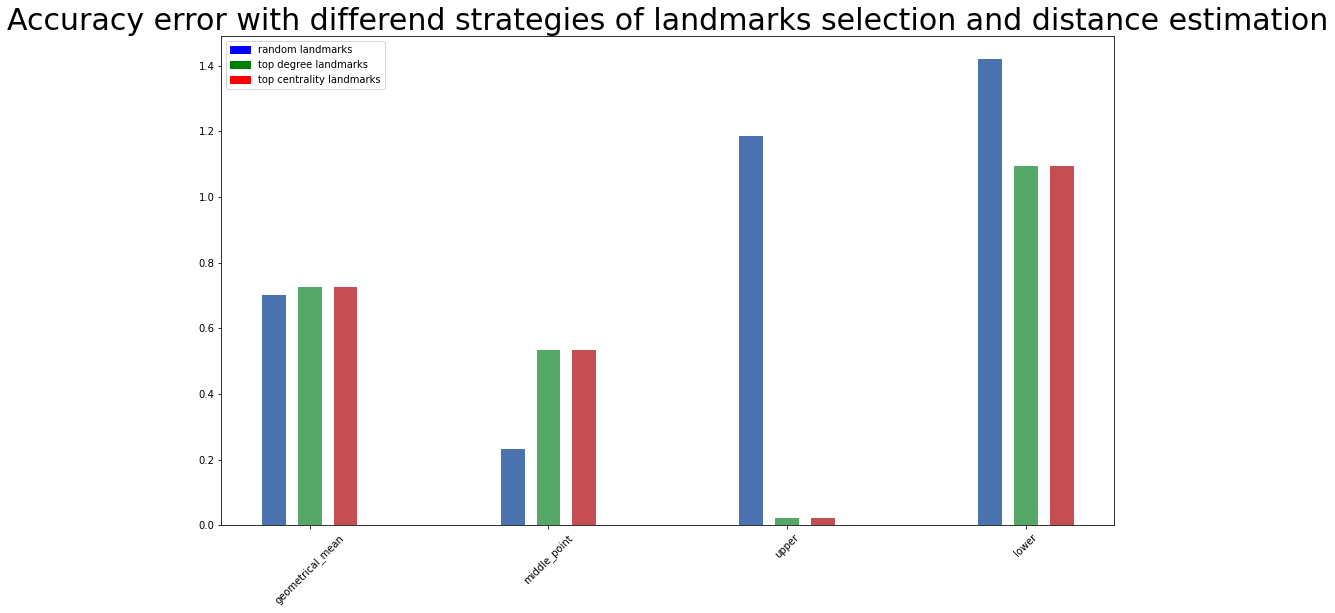

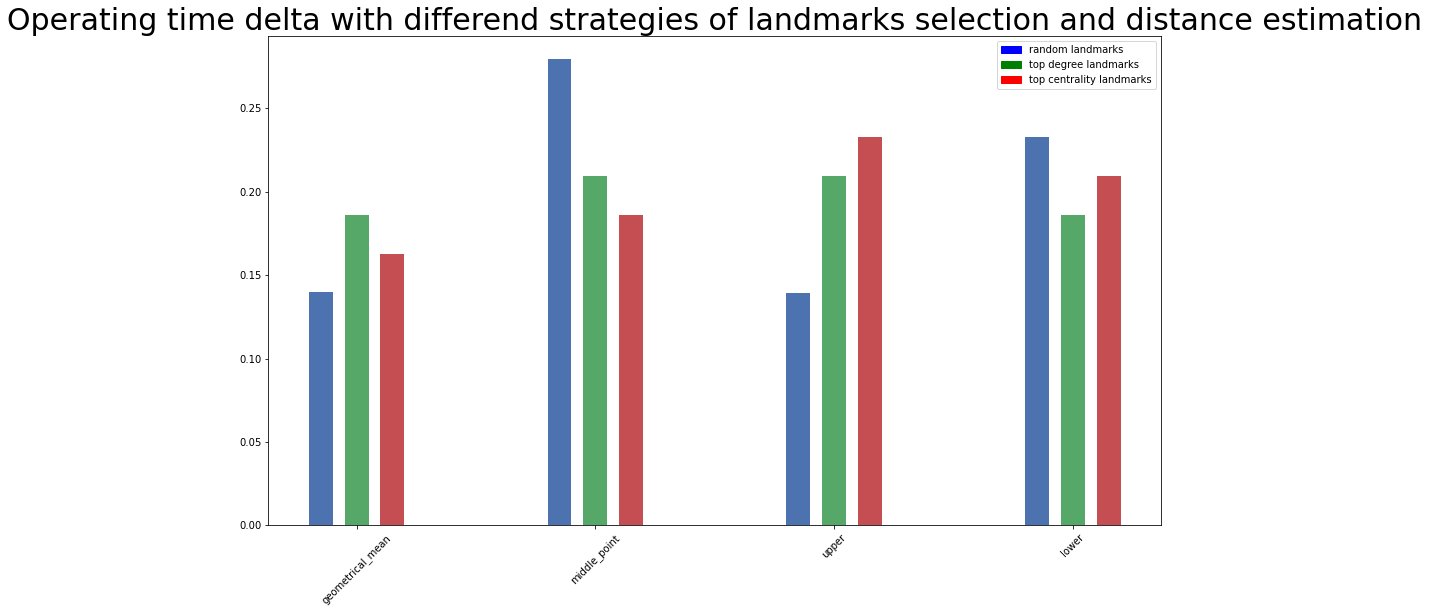

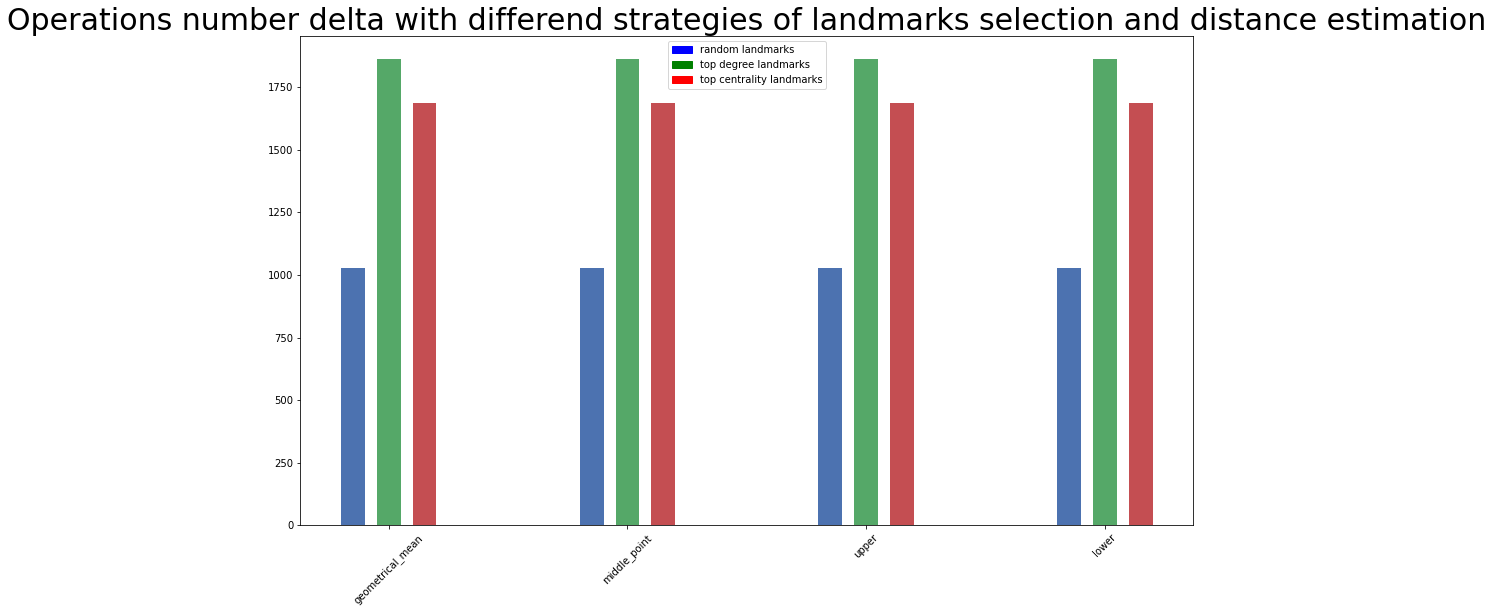

In [169]:
import matplotlib.pyplot as plt
import numpy as np


labels = plot_data['random']['beans']  # choose any landmark selecting strategy
colors = {'random landmarks': 'blue', 'top degree landmarks': 'green', 'top centrality landmarks': 'red'}


# Accuracy error

plt.figure(figsize=(16,9))

y1 = plot_data['random']['accuracy']
y2 = plot_data['degree']['accuracy']
y3 = plot_data['centrality']['accuracy']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)

plt.title('Accuracy error with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

plt.savefig('accuracy_error.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Operating time delta

plt.figure(figsize=(16,9))

y1 = plot_data['random']['time_delta']
y2 = plot_data['degree']['time_delta']
y3 = plot_data['centrality']['time_delta']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)

plt.title('Operating time delta with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

plt.savefig('operating_time_delta.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Operations number delta

plt.figure(figsize=(16,9))

y1 = plot_data['random']['operations_delta']
y2 = plot_data['degree']['operations_delta']
y3 = plot_data['centrality']['operations_delta']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)

plt.title('Operations number delta with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

plt.savefig('operations_number_delta.jpg', dpi=100, bbox_inches='tight')
plt.show()